## Reddit score predictor

This code collects the top posts to a chosen subreddit and then decides if the post will be high scoring or not.
The features for the model are the submission title, whether the submission as additional text, the hour of submission and the day of the week.

Currently the model only classifies as high or low scoring. In future, could classify scores into bands and make the model multi-classification.

### - Import modules -

In [61]:
import os
import time
import praw
import pandas as pd
import numpy as np
import sys 
import matplotlib.pyplot as plt
import seaborn as sns
from random import shuffle

## Libraries for altering text
import nltk
nltk.download('averaged_perceptron_tagger')
import nlpaug.augmenter.word as naw

## libraries for imbalanced data
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight

## Python library for progress bar
from tqdm import tqdm   

## Python library for the wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## libraries for the neural network
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## My functions
from myFunctions import myPrint

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### - Define functions - 

In [62]:
def get_date(created):
    """Function to obtain the date"""
    
    return dt.datetime.fromtimestamp(created)


def reddit_connection():
     """Function to obtain the Reddit submissions"""
        
     personal_use_script = 'PERSONAL_USE_SCRIPT'
     client_secret = 'CLIENT_SECRET'
     user_agent = 'USER AGENT'
     username = 'USERNAME'
     password = 'PASSWORD'
    
     reddit = praw.Reddit(client_id=personal_use_script, \
                          client_secret=client_secret, \
                          user_agent=user_agent, \
                          username=username, \
                          password='')
     return reddit


def build_dataset(reddit, search_words_var, items_limit=None):
    """ Function to build the dataset """

    ## Look at the r/search_words_var subreddit
    subreddit = reddit.subreddit(search_words_var) 
    
    ## Go through a single subreddit submission in hot and obtain all comments
    hot_subreddit = subreddit.hot(limit=items_limit)
    comment_dict = { "title":[], "score":[], "id":[], "url":[], "comms_num":[], "created":[], "body":[]} 

    for submission in tqdm(hot_subreddit):
         comment_dict["title"].append(submission.title)
         comment_dict["score"].append(submission.score)
         comment_dict["id"].append(submission.id)
         comment_dict["url"].append(submission.url)
         comment_dict["comms_num"].append(submission.num_comments)
         comment_dict["created"].append(submission.created)
         comment_dict["body"].append(submission.selftext)

    ## Create a pandas dataframe of the dictionary
    comment_df = pd.DataFrame(comment_dict) 
    print(f"new reddit posts retrieved: {len(comment_df)}") 
    comment_df['timestamp'] = comment_df['created'].apply(lambda x: get_date(x))

    return comment_df 


def update_and_save_dataset(topics_df):   
    """ Function to save the dataset """
    file_path = "reddit_britishproblems.csv" 

    if os.path.exists(file_path):
         # Case where file does exist
         topics_old_df = pd.read_csv(file_path) # read in old file
         print(f"past reddit posts: {topics_old_df.shape}")
         topics_all_df = pd.concat([topics_old_df, topics_df], axis=0) # Join old and new data
         print(f"new reddit posts: {topics_df.shape[0]} past posts: {topics_old_df.shape[0]} all posts: {topics_all_df.shape[0]}")
         topics_new_df = topics_all_df.drop_duplicates(subset = ["id"], keep='last', inplace=False) # Drop any duplicates between data sets
         print(f"all reddit posts: {topics_new_df.shape}")
         topics_new_df.to_csv(file_path, index=False) # Write new file
    else:
         # Case where file doesn't exist yet
         print(f"reddit posts: {topics_df.shape}")
         topics_df.to_csv(file_path, index=False)

def decode_review(text, index):
    """ Function to return text from keys. """
    return ' '.join([index.get(i, '?') for i in text])

### - Form the dataset by using Reddit's API -

In [63]:
## Turn this off by setting database_form to False if we don't want to create/update the dataset
cond = True

## Update the database
while cond:
    yninput = input("Update the database? y/n ")
    try:
        if yninput == 'y':
            database_form = True
            cond = False
        elif yninput == 'n':
            database_form = False
            cond = False
    except:
        print("Invalid input")

if database_form:
    ## Choose the subreddit to explore
    search_words = 'britishproblems' 

    ## Create reddit instance
    reddit = reddit_connection() 

    ## Create the data set
    topics_data_df = build_dataset(reddit, search_words, items_limit=1000) 

    ## Save the data set
    update_and_save_dataset(topics_data_df) 

Update the database? y/n n


### - Analyse the data -

#### Load in the data

In [64]:
dataset = pd.read_csv('reddit_britishproblems.csv')

myPrint(dataset.shape, printmessage="Dataset shape", hold=False)
myPrint(dataset.columns.values, printmessage="Dataset columns", hold=False)

____________________ Dataset shape ____________________
(2134, 8)
____________________ Dataset columns ____________________
['title' 'score' 'id' 'url' 'comms_num' 'created' 'body' 'timestamp']


In [65]:
myPrint(dataset.head(), printmessage="Dataset head", hold=False)
myPrint(dataset.tail(), printmessage="Dataset tail", hold=False)

____________________ Dataset head ____________________
                                               title  score      id  \
0  Pottering around the house for a few minutes d...     54  rz78ei   
1  John Lewis think £600 for a simple shelving un...      9  rzw76s   
2  Local pool closed three hours early because "w...     12  rzu3lh   
3        Loud chavs disturbing my Sunday on the sofa      5  rzwkst   
4                        Sticky toffee cake (GF) (V)      3  rzyqe3   

                                                 url  comms_num       created  \
0  https://www.reddit.com/r/britishproblems/comme...          8  1.641669e+09   
1  https://www.reddit.com/r/britishproblems/comme...          8  1.641748e+09   
2  https://www.reddit.com/r/britishproblems/comme...          4  1.641742e+09   
3  https://www.reddit.com/r/britishproblems/comme...         23  1.641749e+09   
4  https://www.reddit.com/r/britishproblems/comme...          5  1.641755e+09   

                               

#### Turn the time stamp into a datetime and resort the data by the timestamp

In [66]:
dataset['timestamp'] = pd.to_datetime(dataset['timestamp'], errors='coerce')

In [67]:
dataset=dataset.sort_values(['timestamp']).reset_index()
myPrint(dataset.head(), printmessage="Dataset head", hold=False)
myPrint(dataset.tail(), printmessage="Dataset tail", hold=False)
print(dataset['timestamp'].iloc[[0,-1]])

____________________ Dataset head ____________________
   index                                              title  score      id  \
0   1305  Yes mate riding around on your loud bikes all ...  64829  hgqcip   
1    372  When your car breaks down and you have to get ...   4013  rr3872   
2    381  I went to a pub and paid £15 for a pie with on...   2218  rr3g7d   
3    380  Visiting my 90+ year old grandparents and them...   1876  rr4fwp   
4    385     People that use Read Receipts on their emails.   1130  rr4fx4   

                                                 url  comms_num       created  \
0  https://www.reddit.com/r/britishproblems/comme...       1915  1.593249e+09   
1  https://www.reddit.com/r/britishproblems/comme...        494  1.640766e+09   
2  https://www.reddit.com/r/britishproblems/comme...        190  1.640767e+09   
3  https://www.reddit.com/r/britishproblems/comme...        263  1.640771e+09   
4  https://www.reddit.com/r/britishproblems/comme...        152  1.6407

#### Remove the isolated entry from 2020
If we also look at the scores, we can see this entry has an abnormally high score.

<AxesSubplot:xlabel='index', ylabel='score'>

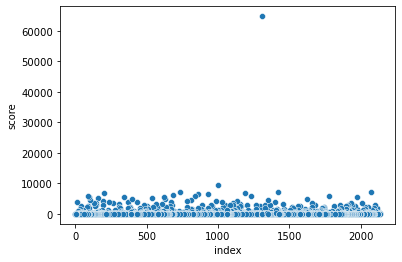

In [68]:
sns.scatterplot(x=dataset['index'], y=dataset['score'])

In [69]:
## Drop the odd entry. 
dataset2=dataset.drop(0, axis=0)
print(dataset2['timestamp'].iloc[[0,-1]])

1      2021-12-29 08:24:20
2133   2022-02-05 11:24:10
Name: timestamp, dtype: datetime64[ns]


#### Look at scores data
Note that the data is heavily skewed. This will be an issue training the model as
a model that just predicts all entries have a low score will perform very well, but hasn't actually learnt anything.

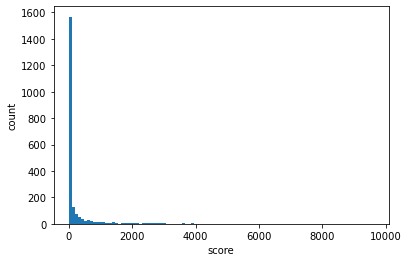

In [70]:
plt.hist(dataset2['score'], 100)
plt.xlabel('score')
plt.ylabel('count')
plt.show()

#### The same histogram as above, but truncated a bit to better see lower scores

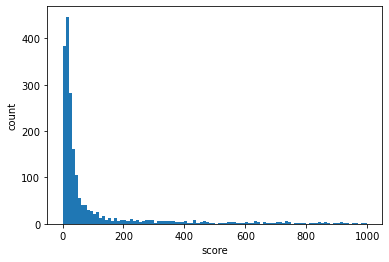

In [71]:
truncated_scores = dataset2['score'].loc[dataset2['score']<1000]
plt.hist(truncated_scores, 100)
plt.xlabel('score')
plt.ylabel('count')
plt.show()

<AxesSubplot:xlabel='index', ylabel='score'>

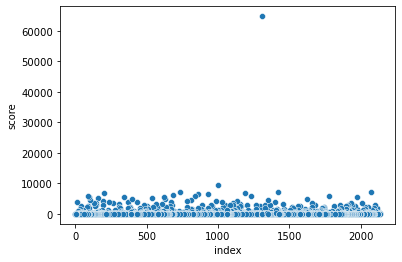

In [72]:
sns.scatterplot(x=dataset['index'], y=dataset['score'])

### Look at text data

#### Look at a few example titles

In [73]:
with pd.option_context('display.max_colwidth', None):
    myPrint(dataset2['title'].head(10), printmessage="Example titles", hold=False)

____________________ Example titles ____________________
1                                                                                                                                                                                                                         When your car breaks down and you have to get towed by Mr Youtube Conspiracy for 2 hours
2                                                                         I went to a pub and paid £15 for a pie with only a hat. No bottom or sides. It was also just a pie. I was dumb enough to assume it would come with potatoes due to the price. To make it worse it was puff pastry instead of shortcrust.
3                                                                                     Visiting my 90+ year old grandparents and them being utterly flabbergasted that I don’t eat red meat and also telling my 4yo son that Captain Marvel can’t be a captain because she’s a girl and couldn’t fight the baddies.
4                     

#### Count of most frequent and total words

In [74]:
print(dataset2['title'].str.split(expand=True).stack().value_counts().iloc[1:40])
print("Total words = ",dataset2['title'].str.split(expand=True).stack().value_counts().sum())

to         1691
a          1345
and        1108
of          892
in          678
on          549
you         549
for         520
I           520
that        388
my          373
is          334
your        325
at          316
it          300
with        281
have        243
not         211
but         210
be          201
when        194
from        192
are         188
out         185
only        183
an          180
The         178
they        177
up          177
as          175
just        166
get         163
me          160
all         159
so          154
being       149
their       146
because     139
has         135
dtype: int64
Total words =  47637


#### Generate a Wordcloud - common words like 'the' automatically set as stopwords

There are 260239 words in the combination of all review.


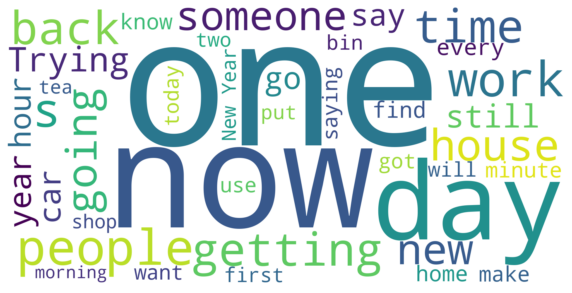

In [75]:
## Join text into single long string
text = " ".join(title for title in dataset2['title'])
print ("There are {} words in the combination of all review.".format(len(text)))

## Generate a word cloud image
#stopwords=[],
wordcloud = WordCloud(width=2000, height=1000, max_words=40, 
                      background_color="white", collocations=True).generate(text)

## Display the generated image
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [76]:
wordcloud.words_

{'one': 1.0,
 'now': 0.950354609929078,
 'day': 0.950354609929078,
 'people': 0.9432624113475178,
 'work': 0.9078014184397163,
 's': 0.8652482269503546,
 'time': 0.8156028368794326,
 'getting': 0.8085106382978723,
 'back': 0.7943262411347518,
 'house': 0.7163120567375887,
 'going': 0.6879432624113475,
 'new': 0.6879432624113475,
 'someone': 0.6453900709219859,
 'Trying': 0.6312056737588653,
 'still': 0.5460992907801419,
 'year': 0.5177304964539007,
 'go': 0.5177304964539007,
 'car': 0.5106382978723404,
 'say': 0.5106382978723404,
 'hour': 0.48936170212765956,
 'every': 0.48226950354609927,
 'find': 0.46808510638297873,
 'know': 0.4397163120567376,
 'home': 0.4397163120567376,
 'minute': 0.425531914893617,
 'make': 0.41134751773049644,
 'got': 0.40425531914893614,
 'use': 0.3971631205673759,
 'want': 0.3971631205673759,
 'saying': 0.3971631205673759,
 'will': 0.3900709219858156,
 'bin': 0.3900709219858156,
 'today': 0.3900709219858156,
 'first': 0.3829787234042553,
 'put': 0.37588652482

### Look at the submission score vs date, day of week and hour of day

#### Create submission date feature

In [77]:
dataset2['date'] = dataset2['timestamp'].dt.date
print(dataset2['date'])

1       2021-12-29
2       2021-12-29
3       2021-12-29
4       2021-12-29
5       2021-12-29
           ...    
2129    2022-02-05
2130    2022-02-05
2131    2022-02-05
2132    2022-02-05
2133    2022-02-05
Name: date, Length: 2133, dtype: object


#### Plot of average submission vs date

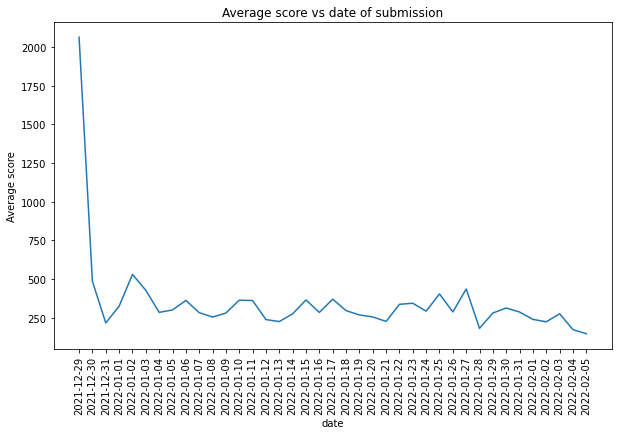

In [78]:
hourset = dataset2[['date','score']].groupby(['date'], as_index=False).mean().sort_values(by='date', ascending=False)
plt.figure(figsize=(10,6))
plt.plot(hourset['date'], hourset['score'])
plt.xticks(hourset['date'])
plt.title('Average score vs date of submission')
plt.ylabel("Average score")
plt.xlabel("date")
plt.xticks(rotation=90)
plt.show()

#### Plot of truncated average submission vs date

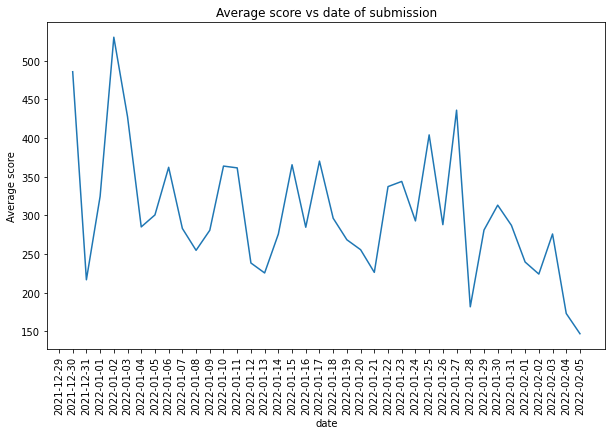

In [79]:
hourset_truncated = hourset.loc[hourset['score']<1000]
plt.figure(figsize=(10,6))
plt.plot(hourset_truncated['date'], hourset_truncated['score'])
plt.xticks(hourset['date'])
plt.title('Average score vs date of submission')
plt.xlabel("date")
plt.ylabel("Average score")
plt.xticks(rotation=90)
plt.show()

#### Create day of the week feature

In [80]:
cats=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dataset2['day_of_week'] = dataset2['timestamp'].dt.day_name()

from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=cats, ordered=True)
dataset2['day_of_week']=dataset2['day_of_week'].astype(cat_type)
print(dataset2['day_of_week'])

1       Wednesday
2       Wednesday
3       Wednesday
4       Wednesday
5       Wednesday
          ...    
2129     Saturday
2130     Saturday
2131     Saturday
2132     Saturday
2133     Saturday
Name: day_of_week, Length: 2133, dtype: category
Categories (7, object): ['Monday' < 'Tuesday' < 'Wednesday' < 'Thursday' < 'Friday' < 'Saturday' < 'Sunday']


#### Plot of average submission score and average number of submission vs day of the week
Clear change in the submission score and number of submissions heading up to Friday. 

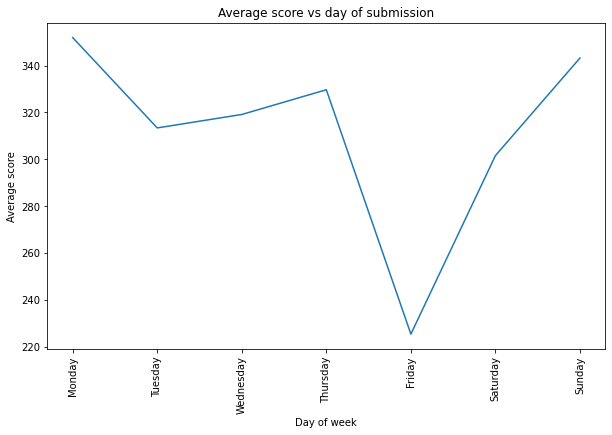

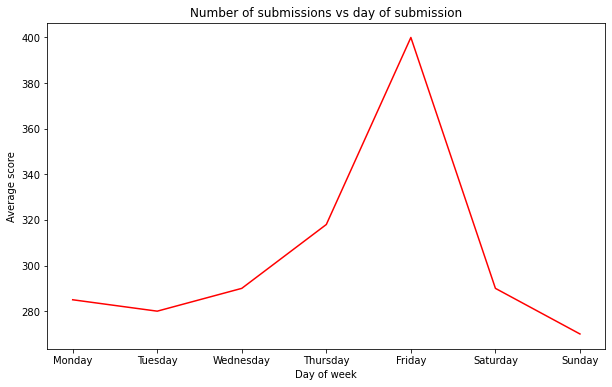

In [81]:
weekset = dataset2[['day_of_week','score']].groupby(['day_of_week'], as_index=False).mean().sort_values(by='day_of_week', ascending=True)
plt.figure(figsize=(10,6))
plt.plot(weekset['day_of_week'], weekset['score'])
plt.xticks(weekset['day_of_week'])
plt.title('Average score vs day of submission')
plt.xlabel("Day of week")
plt.ylabel("Average score")
plt.xticks(rotation=90)
plt.show()

weekset2 = dataset2[['day_of_week']].value_counts().to_frame().reset_index().sort_values(by='day_of_week', ascending=True)
plt.figure(figsize=(10,6))
plt.title('Number of submissions vs day of submission')
plt.xlabel("Day of week")
plt.ylabel("Average score")
plt.plot(weekset2['day_of_week'], weekset2[0], 'red')
plt.show()

#### Create submission hour feature

In [82]:
dataset2['hour'] = dataset2['timestamp'].dt.hour
print(dataset2['hour'])

1        8
2        8
3        9
4        9
5       13
        ..
2129     8
2130     9
2131     9
2132    10
2133    11
Name: hour, Length: 2133, dtype: int64


#### Plot the average score and average number of submissions vs hour of day
Clearly see low submission score and number between midnight and 6am, as expected for the British problems subreddit.
Highest number of scores tend to be in the morning and evenings.

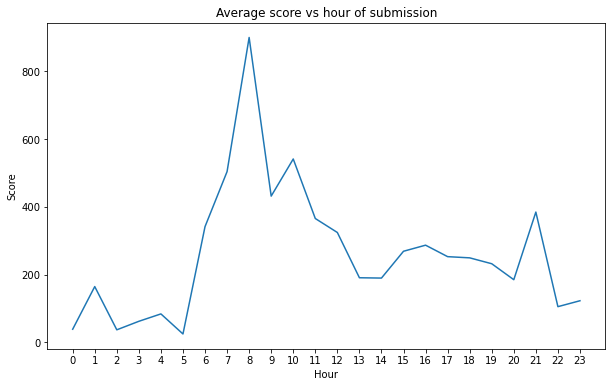

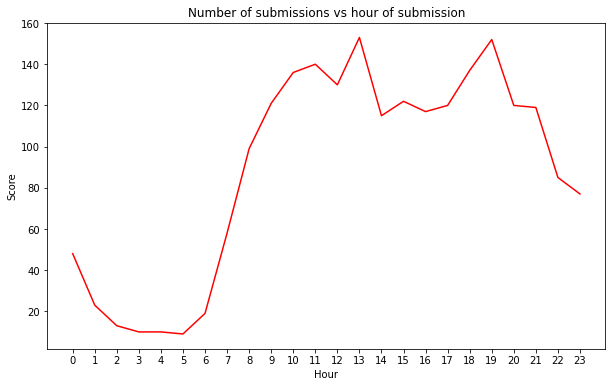

In [83]:
hourset = dataset2[['hour','score']].groupby(['hour'], as_index=False).mean().sort_values(by='hour', ascending=False)
plt.figure(figsize=(10,6))
plt.plot(hourset['hour'], hourset['score'])
plt.xticks(hourset['hour'])
plt.title('Average score vs hour of submission')
plt.xlabel("Hour")
plt.ylabel("Score")

hourset2 = dataset2[['hour']].value_counts().to_frame().reset_index().sort_values(by='hour', ascending=False)
plt.figure(figsize=(10,6))
plt.xticks(hourset['hour'])
plt.title('Number of submissions vs hour of submission')
plt.plot(hourset2['hour'], hourset2[0], 'red')
plt.xlabel("Hour")
plt.ylabel("Score")
plt.show()

### - Create features and labels -

#### Create a comment feature - Additional text other than the submission title is likely to be important

In [84]:
dataset2['subBody'] = (dataset2['body'].isnull()).astype(int)
dataset3=dataset2.drop(['body'], axis=1)
myPrint(dataset3.head(),printmessage="Comment feature", hold=False)

____________________ Comment feature ____________________
   index                                              title  score      id  \
1    372  When your car breaks down and you have to get ...   4013  rr3872   
2    381  I went to a pub and paid £15 for a pie with on...   2218  rr3g7d   
3    380  Visiting my 90+ year old grandparents and them...   1876  rr4fwp   
4    385     People that use Read Receipts on their emails.   1130  rr4fx4   
5    373  Every company replacing their support and cont...   1407  rr8d7z   

                                                 url  comms_num       created  \
1  https://www.reddit.com/r/britishproblems/comme...        494  1.640766e+09   
2  https://www.reddit.com/r/britishproblems/comme...        190  1.640767e+09   
3  https://www.reddit.com/r/britishproblems/comme...        263  1.640771e+09   
4  https://www.reddit.com/r/britishproblems/comme...        152  1.640771e+09   
5  https://www.reddit.com/r/britishproblems/comme...        111  1.6

#### Create a score threshold label. 
We set any score above the mean as 'high scoring' and label with a 1.
We see that this dataset is highly skewed with a ratio of high-scoring quite low

In [85]:
print(dataset3['score'].describe())

count    2133.000000
mean      307.403188
std       869.738382
min         0.000000
25%        13.000000
50%        28.000000
75%       111.000000
max      9605.000000
Name: score, dtype: float64


In [86]:
dataset3['score_label'] = (dataset3['score']>(dataset3['score'].mean())).astype(int)
myPrint(dataset3['score_label'], printmessage="New score feature", hold=False)

____________________ New score feature ____________________
1       1
2       1
3       1
4       1
5       1
       ..
2129    0
2130    0
2131    0
2132    0
2133    0
Name: score_label, Length: 2133, dtype: int32


#### Look at distribution of new score feature

   index  score_label
0      0         1779
1      1          354


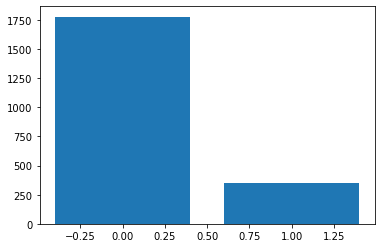

In [87]:
counts=dataset3['score_label'].value_counts().to_frame().reset_index()
print(counts)
plt.bar(counts['index'],counts['score_label'])
plt.show()

#### Assess the 'no skill' model accuracy
This is the accuracy of a model that simply predicts all the submissions are low scoring. It would be correct 83% of the time.

In [88]:
scorecounts = np.bincount(dataset3['score_label'])
noskill_score = scorecounts/len(dataset3['score_label'])
print("no skill score = ", noskill_score)

no skill score =  [0.83403657 0.16596343]


## - Build and train the model -

### Imbalanced data - oversampling
The data we have for our model is quite imbalanced, with around 80% being low-scoring. This could cause issues training the model, and therefore it is worth spending some time modifying the data for training. While getting the classification wrong for this model isn't too much of an issue, imbalanced data is a big issue for other models such as cancer screening, where getting the minority class right is much more important.

There are three techniques commonly used for imbalanced data (not ordered by importance). The first is using a cost-sensitive model where the loss function is adjusted so any errors in the minority class are much more heavily penalized than for the majority class.
The second technique is undersampling, where we reduce the number of majority class data points so the imbalance isn't as severe. This has the issue that we severely reduce our dataset.

The third is oversampling - creating synthetic data for the minority set. This has the issue that the model may pick up unwanted features in the synthetic dataset if the synthetic data isn't very realistic.

Here, we set up oversampling by taking high-scoring submissions, duplicating them and then changing words in the submissions to synonyms. We need to do this first as we have to tokenize the words later.
Undersampling and creating a cost-sensitive loss come later in the notebook.

#### Oversampling - change words to synonyms

In [89]:
oversample=False

if oversample:
    worddataset=dataset3['title'].to_list()

    aug = naw.SynonymAug()
    augmented_data = aug.augment(worddataset)
    
    ## Look at example text. See the results aren't ideal, but will hopefully still be useful for training
    print(augmented_data[6])
    print(worddataset[6])
    
    ## Add synthetic data to dataset
    synthdataset = dataset3.copy()
    synthdataset['title']=augmented_data
    appenddata=synthdataset.loc[synthdataset['score']>dataset3['score'].mean()]
    print(appenddata)

    dataset4=pd.concat([dataset3,appenddata]).reset_index()
else:
    dataset4 = dataset3.copy() ## Set the data if no oversampling

### Tokenize the text data

#### Extract the titles to turn into sequences

In [90]:
new_titles = dataset4['title'].tolist()
new_scores = dataset4['score_label'].tolist()

#### Split the data into train (60%), validation (20%) and test (20%) data sets

In [91]:
training_cut = int(len(new_titles)*0.6) 
validation_cut = int(len(new_titles)*0.8) 

training_titles = new_titles[:training_cut]
training_scores = new_scores[:training_cut]

validation_titles = new_titles[training_cut:validation_cut]
validation_scores = new_scores[training_cut:validation_cut]

testing_titles = new_titles[validation_cut:]
testing_scores = new_scores[validation_cut:]

In [92]:
print(len(training_titles))
print(len(validation_titles))

1279
427


#### Make labels into numpy arrays for use with the network later

In [93]:
Y_train = np.array(training_scores)
Y_valid = np.array(validation_scores)
Y_test = np.array(testing_scores)

#### Set up the tokenizer

In [94]:
## Number of most common words to tokenize
vocab_size = 2000

## Embedding dimension for sentiment
embedding_dim = 16 

## maximum length of sentence. If not specified, padding will pad to length of longest sequence
max_length = 100 

## Where to truncate if sentence too long - choose the end.
trunc_type='post' 

## Where to pad if sentence too short - choose the end.
padding_type='post' 

## Out of value token for any word not in index
oov_tok = "<OOV>" 

## Initialise the tokenizer and apply to the sentences
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{"}~\t\n|',
                      lower=True, split = ' ',)

## Fit the tokenizer on the training set only. Validation and test set should not be used in anyway to build the model
tokenizer.fit_on_texts(training_titles) 

## Obtain the index for the words
word_index = tokenizer.word_index

#### Analyse the word index
Look at the 2000 most common words. Most seem reasonable, although there are some odd letters and symbols that have been tokenized and should be removed to improve the model.

In [95]:
print("{:<15} {:<10}".format('Label','Number'))
for k, v in word_index.items():
    label = k
    num = v
    print("{:<15} {:<10}".format(label, num))

Label           Number    
<OOV>           1         
the             2         
to              3         
a               4         
and             5         
of              6         
in              7         
you             8         
on              9         
i               10        
for             11        
my              12        
that            13        
it              14        
is              15        
your            16        
when            17        
at              18        
with            19        
have            20        
not             21        
being           22        
but             23        
only            24        
just            25        
up              26        
me              27        
be              28        
they            29        
are             30        
out             31        
an              32        
all             33        
get             34        
as              35        
from            36        
h

newcastle       1704      
write           1705      
damn            1706      
mini            1707      
plates          1708      
knife           1709      
upgrade         1710      
tells           1711      
2023            1712      
unloading       1713      
trolley         1714      
crumpets        1715      
specifically    1716      
crunchy         1717      
stores          1718      
garlic          1719      
vegetables      1720      
searching       1721      
vouchers        1722      
gregg's         1723      
booked          1724      
whoever         1725      
puddle          1726      
soaked          1727      
cockwombles     1728      
karen           1729      
hitting         1730      
summer          1731      
apps            1732      
chase           1733      
overflowing     1734      
leftover        1735      
rice            1736      
spreadable      1737      
virus           1738      
casual          1739      
emptied         1740      
r

'candy'         3204      
meals           3205      
liners          3206      
garbage         3207      
leak            3208      
active          3209      
stuffed         3210      
bradley         3211      
walsh           3212      
faulting        3213      
players         3214      
shia            3215      
labeouf         3216      
returng         3217      
bublé           3218      
triangles       3219      
helps           3220      
dickheads       3221      
chain           3222      
pitchers        3223      
containers      3224      
stops           3225      
massively       3226      
duration        3227      
compete         3228      
digestives      3229      
compilation     3230      
nfl             3231      
nba             3232      
mlb             3233      
“literal        3234      
tests”          3235      
covis”          3236      
cant            3237      
handle          3238      
ackward         3239      
built           3240      
d

lingering       4703      
ibuprofen       4704      
limited         4705      
tablet          4706      
scales          4707      
arrested        4708      
speech          4709      
gotten          4710      
50min           4711      
utility         4712      
doubled         4713      
tide            4714      
disappointingly 4715      
pour            4716      
cone            4717      
failed          4718      
mot             4719      
doings          4720      
river           4721      
stepped         4722      
diarrhoea       4723      
nicest          4724      
thickest        4725      
compared        4726      
genuine         4727      
italian         4728      
bella           4729      
italia          4730      
rastamouse      4731      
characters      4732      
cause           4733      
effing          4734      
rang            4735      
hurting         4736      
pee             4737      
ajar            4738      
detail          4739      
g

#### Turn into sequences

In [96]:
train_sequences = tokenizer.texts_to_sequences(training_titles)
X_train = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(validation_titles) 
X_valid = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_titles)
X_test = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

#### Create a reverse word index to obtain words from the tokens
Look at some examples and compare to the main text to see how many OOV tokens.

In [97]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
for i in range(10):
    print(decode_review(train_sequences[i], reverse_word_index))
    print(training_titles[i], "\n")

when your car <OOV> down and you have to get <OOV> by <OOV> youtube <OOV> for 2 hours
When your car breaks down and you have to get towed by Mr Youtube Conspiracy for 2 hours 

i went to a pub and paid £15 for a pie with only a hat no bottom or sides it was also just a pie i was <OOV> enough to <OOV> it would come with potatoes due to the price to make it worse it was puff pastry instead of <OOV>
I went to a pub and paid £15 for a pie with only a hat. No bottom or sides. It was also just a pie. I was dumb enough to assume it would come with potatoes due to the price. To make it worse it was puff pastry instead of shortcrust. 

visiting my 90 year old grandparents and them being <OOV> <OOV> that i don’t eat red meat and also telling my 4yo son that captain <OOV> can’t be a captain because she’s a girl and <OOV> <OOV> the <OOV>
Visiting my 90+ year old grandparents and them being utterly flabbergasted that I don’t eat red meat and also telling my 4yo son that Captain Marvel can’t be a ca

### Create second dataset for categorical time features

#### Select the body, hour and day of week columns

In [98]:
X_cat=dataset4[['subBody','hour','day_of_week']]
print(X_cat)

      subBody  hour day_of_week
1           1     8   Wednesday
2           0     8   Wednesday
3           0     9   Wednesday
4           0     9   Wednesday
5           0    13   Wednesday
...       ...   ...         ...
2129        0     8    Saturday
2130        1     9    Saturday
2131        0     9    Saturday
2132        0    10    Saturday
2133        1    11    Saturday

[2133 rows x 3 columns]


#### Create dummies for days of the week

In [99]:
dummies=pd.get_dummies(X_cat['day_of_week'])
print(dummies)

X_cat2=pd.concat([X_cat,dummies],axis=1).drop('day_of_week',axis=1)
print(X_cat2)

      Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
1          0        0          1         0       0         0       0
2          0        0          1         0       0         0       0
3          0        0          1         0       0         0       0
4          0        0          1         0       0         0       0
5          0        0          1         0       0         0       0
...      ...      ...        ...       ...     ...       ...     ...
2129       0        0          0         0       0         1       0
2130       0        0          0         0       0         1       0
2131       0        0          0         0       0         1       0
2132       0        0          0         0       0         1       0
2133       0        0          0         0       0         1       0

[2133 rows x 7 columns]
      subBody  hour  Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  \
1           1     8       0        0          1         0       0   

#### Scale hour feature so between 0 and 1

In [100]:
X_cat3=X_cat2.copy()
X_cat3[['hour']]=X_cat3[['hour']].loc[:]/23
print(X_cat3)

      subBody      hour  Monday  Tuesday  Wednesday  Thursday  Friday  \
1           1  0.347826       0        0          1         0       0   
2           0  0.347826       0        0          1         0       0   
3           0  0.391304       0        0          1         0       0   
4           0  0.391304       0        0          1         0       0   
5           0  0.565217       0        0          1         0       0   
...       ...       ...     ...      ...        ...       ...     ...   
2129        0  0.347826       0        0          0         0       0   
2130        1  0.391304       0        0          0         0       0   
2131        0  0.391304       0        0          0         0       0   
2132        0  0.434783       0        0          0         0       0   
2133        1  0.478261       0        0          0         0       0   

      Saturday  Sunday  
1            0       0  
2            0       0  
3            0       0  
4            0       0 

#### Split the final data into train, validation and test

In [101]:
## Note that loc is end inclusive hence the +1 
X_cat3 = X_cat2.copy()
X_train_other = np.array(X_cat3.loc[:training_cut])
X_valid_other = np.array(X_cat3.loc[training_cut+1:validation_cut])
X_test_other = np.array(X_cat3.loc[validation_cut+1:])

new_scores = dataset3['score_label'].tolist()

#### Checking data lengths correct

In [102]:
print(len(X_train_other), " ", len(X_train))

print(len(X_valid_other), " ", len(X_valid))

print(len(X_test_other), " ",len(X_test))

1279   1279
427   427
427   427


### Imbalanced data prep - cost-sensitive loss and undersampling

#### Create weights for a cost-sensitive loss
The weights won't be used if the data is over- and/or undersampled.

In [103]:
weights = class_weight.compute_class_weight(class_weight = "balanced",
                                       classes = np.unique(Y_train),
                                       y = Y_train)

weights = dict(zip(np.unique(Y_train), weights))
print(weights)

{0: 0.5993439550140581, 1: 3.016509433962264}


#### Undersample data
Select a random assortment of the majority class up to some limit

In [104]:
undersample=False

if undersample:
    ## First find where labels where the data is high scoring and low scoring
    one_labels=np.argwhere(Y_train==1)
    zero_labels=np.argwhere(Y_train==0)

    zerolabellist=zero_labels.flatten().tolist()
    onelabellist=one_labels.flatten().tolist()

    ## Don't need to undersample so populations completely equal. Instead have ratio minority:majority =  1:scale
    scale=2 

    ## Take a random assortment of the majority data
    szero_labels=shuffle(zerolabellist)
    new_zero_list_rnd = [zerolabellist[i] for i in range(scale*len(one_labels))]

    ind_list = new_zero_list_rnd + onelabellist
    print(len(ind_list))

    sX_train=X_train[ind_list,:] 
    sX_train_other=X_train_other[ind_list,:]
    sY_train=Y_train[ind_list,]
else:
    ## Set the training data -- note we drop the last data point as the total data size is prime, 
    ## and we want a divisible number for the mini batches
    sX_train=X_train[:-1]
    sX_train_other=X_train_other[:-1]
    sY_train=Y_train[:-1]

### Combine features and Embedding into a single model. -edit
We have both text and categorical features with which to train the model. However, because of the tokenizing and embedding we can't use the categorial features on the language part of the neural network, otherwise our features will be mixed with text. Therefore, we instead create a multiple input model by stacking the models end-to-end.

In [105]:
tf.keras.backend.clear_session()

## Language model
input_1 = tf.keras.layers.Input(shape=(100,), name="input", )
embedding_1 = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length)(input_1)
flatten_1 = tf.keras.layers.Flatten()(embedding_1)
dense_1 = tf.keras.layers.Dense(2, activation='relu')(flatten_1)


## Categorical model - Uses subbody, hour and weekday dummy features
input_2 = tf.keras.layers.Input(shape=(9,))
dense_2 = tf.keras.layers.Dense(5, activation=tf.keras.activations.relu)(input_2)

## Combine the models 
concat = tf.keras.layers.Concatenate()([dense_1, dense_2])

## Create the output layer - Binary output
output=tf.keras.layers.Dense(1, activation='sigmoid')(concat)

## Combined model
model = tf.keras.Model(inputs=[input_1, input_2], outputs=[output]) 

In [106]:
auc=tf.keras.metrics.AUC(num_thresholds=200, curve='PR',summation_method='interpolation')

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),##could modify
              weighted_metrics=['accuracy', auc],) ## might cause error if weighted

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 16)      32000       ['input[0][0]']                  
                                                                                                  
 flatten (Flatten)              (None, 1600)         0           ['embedding[0][0]']              
                                                                                                  
 input_1 (InputLayer)           [(None, 9)]          0           []                               
                                                                                              

#### Train the network
Train over 1000 epochs. Use minibatches and shuffle to avoid local minimisation.

In [107]:
num_epochs = 1000
no_weights = {0:1, 1:1}

## If we want to use a weighted cost-sensitive cost function, choose used_weights = weights.
used_weights = weights  
b_size=18
history = model.fit([sX_train, sX_train_other],
                    sY_train,
                    epochs=num_epochs,
                    validation_data=([X_valid, X_valid_other], Y_valid),
                    class_weight=used_weights,
                    shuffle=True, batch_size=b_size) 

Epoch 1/1000
71/71 [==============================] - 1s 3ms/step - loss: 4.5828 - accuracy: 0.5002 - auc: 0.4872 - val_loss: 7.5124 - val_accuracy: 0.1733 - val_auc: 0.1648
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 4.5586 - accuracy: 0.5016 - auc: 0.4852 - val_loss: 7.4716 - val_accuracy: 0.1780 - val_auc: 0.1633
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 4.5340 - accuracy: 0.5035 - auc: 0.4813 - val_loss: 7.4306 - val_accuracy: 0.1803 - val_auc: 0.1600
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 4.5093 - accuracy: 0.5035 - auc: 0.4781 - val_loss: 7.3892 - val_accuracy: 0.1803 - val_auc: 0.1602
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 4.4843 - accuracy: 0.5035 - auc: 0.4781 - val_loss: 7.3474 - val_accuracy: 0.1803 - val_auc: 0.1583
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 4.4588 - accuracy: 0.5035 - auc: 0.4783 - val_loss: 7.30

Epoch 48/1000
71/71 [==============================] - 0s 1ms/step - loss: 2.6218 - accuracy: 0.5161 - auc: 0.4627 - val_loss: 4.1391 - val_accuracy: 0.2014 - val_auc: 0.1436
Epoch 49/1000
71/71 [==============================] - 0s 1ms/step - loss: 2.5696 - accuracy: 0.5165 - auc: 0.4621 - val_loss: 4.0454 - val_accuracy: 0.2061 - val_auc: 0.1425
Epoch 50/1000
71/71 [==============================] - 0s 1ms/step - loss: 2.5179 - accuracy: 0.5127 - auc: 0.4624 - val_loss: 3.9515 - val_accuracy: 0.2108 - val_auc: 0.1408
Epoch 51/1000
71/71 [==============================] - 0s 1ms/step - loss: 2.4668 - accuracy: 0.5146 - auc: 0.4613 - val_loss: 3.8583 - val_accuracy: 0.2131 - val_auc: 0.1422
Epoch 52/1000
71/71 [==============================] - 0s 1ms/step - loss: 2.4161 - accuracy: 0.5132 - auc: 0.4634 - val_loss: 3.7664 - val_accuracy: 0.2178 - val_auc: 0.1432
Epoch 53/1000
71/71 [==============================] - 0s 1ms/step - loss: 2.3662 - accuracy: 0.5066 - auc: 0.4637 - val_loss

Epoch 95/1000
71/71 [==============================] - 0s 1ms/step - loss: 1.3897 - accuracy: 0.4700 - auc: 0.4668 - val_loss: 1.4398 - val_accuracy: 0.4403 - val_auc: 0.1536
Epoch 96/1000
71/71 [==============================] - 0s 1ms/step - loss: 1.3861 - accuracy: 0.4705 - auc: 0.4679 - val_loss: 1.4235 - val_accuracy: 0.4473 - val_auc: 0.1539
Epoch 97/1000
71/71 [==============================] - 0s 1ms/step - loss: 1.3827 - accuracy: 0.4667 - auc: 0.4666 - val_loss: 1.4104 - val_accuracy: 0.4473 - val_auc: 0.1532
Epoch 98/1000
71/71 [==============================] - 0s 1ms/step - loss: 1.3794 - accuracy: 0.4695 - auc: 0.4662 - val_loss: 1.3979 - val_accuracy: 0.4543 - val_auc: 0.1540
Epoch 99/1000
71/71 [==============================] - 0s 1ms/step - loss: 1.3766 - accuracy: 0.4723 - auc: 0.4665 - val_loss: 1.3848 - val_accuracy: 0.4543 - val_auc: 0.1536
Epoch 100/1000
71/71 [==============================] - 0s 1ms/step - loss: 1.3737 - accuracy: 0.4728 - auc: 0.4667 - val_los

71/71 [==============================] - 0s 1ms/step - loss: 1.2891 - accuracy: 0.4877 - auc: 0.4759 - val_loss: 1.1942 - val_accuracy: 0.4918 - val_auc: 0.1570
Epoch 142/1000
71/71 [==============================] - 0s 1ms/step - loss: 1.2871 - accuracy: 0.4867 - auc: 0.4761 - val_loss: 1.1940 - val_accuracy: 0.4918 - val_auc: 0.1570
Epoch 143/1000
71/71 [==============================] - 0s 1ms/step - loss: 1.2850 - accuracy: 0.4882 - auc: 0.4766 - val_loss: 1.1915 - val_accuracy: 0.4918 - val_auc: 0.1570
Epoch 144/1000
71/71 [==============================] - 0s 1ms/step - loss: 1.2830 - accuracy: 0.4877 - auc: 0.4767 - val_loss: 1.1901 - val_accuracy: 0.4918 - val_auc: 0.1569
Epoch 145/1000
71/71 [==============================] - 0s 1ms/step - loss: 1.2811 - accuracy: 0.4882 - auc: 0.4767 - val_loss: 1.1876 - val_accuracy: 0.4918 - val_auc: 0.1569
Epoch 146/1000
71/71 [==============================] - 0s 1ms/step - loss: 1.2790 - accuracy: 0.4882 - auc: 0.4773 - val_loss: 1.1856 

Epoch 188/1000
71/71 [==============================] - 0s 1ms/step - loss: 1.1954 - accuracy: 0.4962 - auc: 0.4820 - val_loss: 1.1161 - val_accuracy: 0.4965 - val_auc: 0.1550
Epoch 189/1000
71/71 [==============================] - 0s 1ms/step - loss: 1.1933 - accuracy: 0.4962 - auc: 0.4822 - val_loss: 1.1138 - val_accuracy: 0.4965 - val_auc: 0.1549
Epoch 190/1000
71/71 [==============================] - 0s 1ms/step - loss: 1.1914 - accuracy: 0.4962 - auc: 0.4825 - val_loss: 1.1115 - val_accuracy: 0.4965 - val_auc: 0.1552
Epoch 191/1000
71/71 [==============================] - 0s 1ms/step - loss: 1.1893 - accuracy: 0.4962 - auc: 0.4829 - val_loss: 1.1125 - val_accuracy: 0.4965 - val_auc: 0.1551
Epoch 192/1000
71/71 [==============================] - 0s 1ms/step - loss: 1.1874 - accuracy: 0.4962 - auc: 0.4835 - val_loss: 1.1098 - val_accuracy: 0.4965 - val_auc: 0.1552
Epoch 193/1000
71/71 [==============================] - 0s 1ms/step - loss: 1.1854 - accuracy: 0.4962 - auc: 0.4833 - va

71/71 [==============================] - 0s 1ms/step - loss: 1.1052 - accuracy: 0.5018 - auc: 0.4941 - val_loss: 1.0496 - val_accuracy: 0.5035 - val_auc: 0.1570
Epoch 235/1000
71/71 [==============================] - 0s 1ms/step - loss: 1.1031 - accuracy: 0.5018 - auc: 0.4942 - val_loss: 1.0487 - val_accuracy: 0.5035 - val_auc: 0.1573
Epoch 236/1000
71/71 [==============================] - 0s 1ms/step - loss: 1.1011 - accuracy: 0.5023 - auc: 0.4947 - val_loss: 1.0481 - val_accuracy: 0.5059 - val_auc: 0.1574
Epoch 237/1000
71/71 [==============================] - 0s 1ms/step - loss: 1.0992 - accuracy: 0.5018 - auc: 0.4945 - val_loss: 1.0466 - val_accuracy: 0.5059 - val_auc: 0.1563
Epoch 238/1000
71/71 [==============================] - 0s 1ms/step - loss: 1.0972 - accuracy: 0.5023 - auc: 0.4950 - val_loss: 1.0454 - val_accuracy: 0.5059 - val_auc: 0.1559
Epoch 239/1000
71/71 [==============================] - 0s 1ms/step - loss: 1.0952 - accuracy: 0.5023 - auc: 0.4955 - val_loss: 1.0444 

Epoch 281/1000
71/71 [==============================] - 0s 1ms/step - loss: 1.0133 - accuracy: 0.5074 - auc: 0.5065 - val_loss: 0.9876 - val_accuracy: 0.5035 - val_auc: 0.1588
Epoch 282/1000
71/71 [==============================] - 0s 1ms/step - loss: 1.0116 - accuracy: 0.5070 - auc: 0.5071 - val_loss: 0.9877 - val_accuracy: 0.5035 - val_auc: 0.1588
Epoch 283/1000
71/71 [==============================] - 0s 1ms/step - loss: 1.0096 - accuracy: 0.5070 - auc: 0.5072 - val_loss: 0.9835 - val_accuracy: 0.5035 - val_auc: 0.1587
Epoch 284/1000
71/71 [==============================] - 0s 1ms/step - loss: 1.0077 - accuracy: 0.5079 - auc: 0.5078 - val_loss: 0.9827 - val_accuracy: 0.5035 - val_auc: 0.1588
Epoch 285/1000
71/71 [==============================] - 0s 1ms/step - loss: 1.0058 - accuracy: 0.5070 - auc: 0.5082 - val_loss: 0.9820 - val_accuracy: 0.5035 - val_auc: 0.1587
Epoch 286/1000
71/71 [==============================] - 0s 1ms/step - loss: 1.0040 - accuracy: 0.5079 - auc: 0.5087 - va

71/71 [==============================] - 0s 1ms/step - loss: 0.9305 - accuracy: 0.5220 - auc: 0.5266 - val_loss: 0.9284 - val_accuracy: 0.5152 - val_auc: 0.1608
Epoch 328/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.9288 - accuracy: 0.5220 - auc: 0.5273 - val_loss: 0.9284 - val_accuracy: 0.5129 - val_auc: 0.1607
Epoch 329/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.9271 - accuracy: 0.5244 - auc: 0.5271 - val_loss: 0.9269 - val_accuracy: 0.5152 - val_auc: 0.1608
Epoch 330/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.9253 - accuracy: 0.5244 - auc: 0.5282 - val_loss: 0.9265 - val_accuracy: 0.5152 - val_auc: 0.1607
Epoch 331/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.9238 - accuracy: 0.5253 - auc: 0.5285 - val_loss: 0.9252 - val_accuracy: 0.5152 - val_auc: 0.1607
Epoch 332/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.9219 - accuracy: 0.5267 - auc: 0.5290 - val_loss: 0.9248 

Epoch 374/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.8505 - accuracy: 0.5493 - auc: 0.5543 - val_loss: 0.8773 - val_accuracy: 0.5222 - val_auc: 0.1621
Epoch 375/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.8488 - accuracy: 0.5498 - auc: 0.5549 - val_loss: 0.8770 - val_accuracy: 0.5222 - val_auc: 0.1620
Epoch 376/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.8472 - accuracy: 0.5502 - auc: 0.5560 - val_loss: 0.8751 - val_accuracy: 0.5222 - val_auc: 0.1620
Epoch 377/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.8455 - accuracy: 0.5493 - auc: 0.5564 - val_loss: 0.8745 - val_accuracy: 0.5222 - val_auc: 0.1618
Epoch 378/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.8439 - accuracy: 0.5517 - auc: 0.5570 - val_loss: 0.8740 - val_accuracy: 0.5222 - val_auc: 0.1617
Epoch 379/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.8422 - accuracy: 0.5521 - auc: 0.5581 - va

71/71 [==============================] - 0s 1ms/step - loss: 0.7754 - accuracy: 0.5738 - auc: 0.5906 - val_loss: 0.8330 - val_accuracy: 0.5316 - val_auc: 0.1648
Epoch 421/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.7737 - accuracy: 0.5738 - auc: 0.5912 - val_loss: 0.8315 - val_accuracy: 0.5340 - val_auc: 0.1648
Epoch 422/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.7721 - accuracy: 0.5742 - auc: 0.5927 - val_loss: 0.8290 - val_accuracy: 0.5340 - val_auc: 0.1653
Epoch 423/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.7705 - accuracy: 0.5747 - auc: 0.5935 - val_loss: 0.8296 - val_accuracy: 0.5340 - val_auc: 0.1652
Epoch 424/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.7689 - accuracy: 0.5752 - auc: 0.5941 - val_loss: 0.8286 - val_accuracy: 0.5340 - val_auc: 0.1657
Epoch 425/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.7674 - accuracy: 0.5752 - auc: 0.5955 - val_loss: 0.8279 

Epoch 467/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.7014 - accuracy: 0.6077 - auc: 0.6436 - val_loss: 0.7894 - val_accuracy: 0.5550 - val_auc: 0.1689
Epoch 468/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.6999 - accuracy: 0.6077 - auc: 0.6446 - val_loss: 0.7899 - val_accuracy: 0.5527 - val_auc: 0.1689
Epoch 469/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.6983 - accuracy: 0.6077 - auc: 0.6467 - val_loss: 0.7870 - val_accuracy: 0.5550 - val_auc: 0.1687
Epoch 470/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.6968 - accuracy: 0.6091 - auc: 0.6474 - val_loss: 0.7868 - val_accuracy: 0.5550 - val_auc: 0.1683
Epoch 471/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.6952 - accuracy: 0.6086 - auc: 0.6487 - val_loss: 0.7862 - val_accuracy: 0.5550 - val_auc: 0.1682
Epoch 472/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.6939 - accuracy: 0.6124 - auc: 0.6495 - va

71/71 [==============================] - 0s 1ms/step - loss: 0.6297 - accuracy: 0.6542 - auc: 0.7118 - val_loss: 0.7472 - val_accuracy: 0.5644 - val_auc: 0.1715
Epoch 514/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.6282 - accuracy: 0.6533 - auc: 0.7130 - val_loss: 0.7479 - val_accuracy: 0.5621 - val_auc: 0.1715
Epoch 515/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.6266 - accuracy: 0.6547 - auc: 0.7150 - val_loss: 0.7470 - val_accuracy: 0.5621 - val_auc: 0.1719
Epoch 516/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.6251 - accuracy: 0.6547 - auc: 0.7165 - val_loss: 0.7456 - val_accuracy: 0.5621 - val_auc: 0.1720
Epoch 517/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.6236 - accuracy: 0.6589 - auc: 0.7184 - val_loss: 0.7463 - val_accuracy: 0.5644 - val_auc: 0.1721
Epoch 518/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.6220 - accuracy: 0.6618 - auc: 0.7195 - val_loss: 0.7448 

Epoch 560/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.5609 - accuracy: 0.7154 - auc: 0.7906 - val_loss: 0.7158 - val_accuracy: 0.5761 - val_auc: 0.1765
Epoch 561/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.5595 - accuracy: 0.7159 - auc: 0.7924 - val_loss: 0.7145 - val_accuracy: 0.5761 - val_auc: 0.1767
Epoch 562/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.5581 - accuracy: 0.7182 - auc: 0.7943 - val_loss: 0.7140 - val_accuracy: 0.5761 - val_auc: 0.1767
Epoch 563/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.5567 - accuracy: 0.7229 - auc: 0.7961 - val_loss: 0.7148 - val_accuracy: 0.5761 - val_auc: 0.1767
Epoch 564/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.5553 - accuracy: 0.7224 - auc: 0.7978 - val_loss: 0.7114 - val_accuracy: 0.5761 - val_auc: 0.1760
Epoch 565/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.5539 - accuracy: 0.7291 - auc: 0.7994 - va

71/71 [==============================] - 0s 1ms/step - loss: 0.5026 - accuracy: 0.7775 - auc: 0.8597 - val_loss: 0.6944 - val_accuracy: 0.5925 - val_auc: 0.1780
Epoch 607/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.5014 - accuracy: 0.7803 - auc: 0.8607 - val_loss: 0.6950 - val_accuracy: 0.5902 - val_auc: 0.1782
Epoch 608/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.5002 - accuracy: 0.7803 - auc: 0.8622 - val_loss: 0.6937 - val_accuracy: 0.5902 - val_auc: 0.1778
Epoch 609/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.4991 - accuracy: 0.7803 - auc: 0.8632 - val_loss: 0.6928 - val_accuracy: 0.5972 - val_auc: 0.1781
Epoch 610/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.4978 - accuracy: 0.7827 - auc: 0.8646 - val_loss: 0.6933 - val_accuracy: 0.5948 - val_auc: 0.1779
Epoch 611/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.4966 - accuracy: 0.7846 - auc: 0.8657 - val_loss: 0.6928 

Epoch 653/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.4478 - accuracy: 0.8236 - auc: 0.9112 - val_loss: 0.6722 - val_accuracy: 0.6230 - val_auc: 0.1792
Epoch 654/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.4467 - accuracy: 0.8226 - auc: 0.9121 - val_loss: 0.6730 - val_accuracy: 0.6159 - val_auc: 0.1790
Epoch 655/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.4455 - accuracy: 0.8255 - auc: 0.9131 - val_loss: 0.6722 - val_accuracy: 0.6206 - val_auc: 0.1795
Epoch 656/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.4444 - accuracy: 0.8269 - auc: 0.9139 - val_loss: 0.6712 - val_accuracy: 0.6253 - val_auc: 0.1795
Epoch 657/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.4433 - accuracy: 0.8287 - auc: 0.9148 - val_loss: 0.6705 - val_accuracy: 0.6230 - val_auc: 0.1795
Epoch 658/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.4421 - accuracy: 0.8292 - auc: 0.9155 - va

71/71 [==============================] - 0s 1ms/step - loss: 0.3966 - accuracy: 0.8763 - auc: 0.9460 - val_loss: 0.6529 - val_accuracy: 0.6323 - val_auc: 0.1816
Epoch 700/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.3956 - accuracy: 0.8763 - auc: 0.9465 - val_loss: 0.6525 - val_accuracy: 0.6323 - val_auc: 0.1813
Epoch 701/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.3945 - accuracy: 0.8781 - auc: 0.9472 - val_loss: 0.6511 - val_accuracy: 0.6323 - val_auc: 0.1814
Epoch 702/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.3934 - accuracy: 0.8781 - auc: 0.9477 - val_loss: 0.6508 - val_accuracy: 0.6323 - val_auc: 0.1814
Epoch 703/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.3923 - accuracy: 0.8781 - auc: 0.9483 - val_loss: 0.6508 - val_accuracy: 0.6323 - val_auc: 0.1815
Epoch 704/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.3913 - accuracy: 0.8786 - auc: 0.9489 - val_loss: 0.6503 

Epoch 746/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.3476 - accuracy: 0.9087 - auc: 0.9683 - val_loss: 0.6323 - val_accuracy: 0.6534 - val_auc: 0.1838
Epoch 747/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.3466 - accuracy: 0.9115 - auc: 0.9687 - val_loss: 0.6329 - val_accuracy: 0.6534 - val_auc: 0.1837
Epoch 748/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.3456 - accuracy: 0.9111 - auc: 0.9690 - val_loss: 0.6328 - val_accuracy: 0.6534 - val_auc: 0.1837
Epoch 749/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.3446 - accuracy: 0.9143 - auc: 0.9693 - val_loss: 0.6321 - val_accuracy: 0.6534 - val_auc: 0.1839
Epoch 750/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.3436 - accuracy: 0.9162 - auc: 0.9696 - val_loss: 0.6310 - val_accuracy: 0.6557 - val_auc: 0.1833
Epoch 751/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.3426 - accuracy: 0.9162 - auc: 0.9699 - va

71/71 [==============================] - 0s 1ms/step - loss: 0.3036 - accuracy: 0.9280 - auc: 0.9820 - val_loss: 0.6163 - val_accuracy: 0.6815 - val_auc: 0.1879
Epoch 793/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.3026 - accuracy: 0.9284 - auc: 0.9822 - val_loss: 0.6155 - val_accuracy: 0.6792 - val_auc: 0.1879
Epoch 794/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.3017 - accuracy: 0.9284 - auc: 0.9824 - val_loss: 0.6151 - val_accuracy: 0.6792 - val_auc: 0.1877
Epoch 795/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.3008 - accuracy: 0.9289 - auc: 0.9826 - val_loss: 0.6144 - val_accuracy: 0.6838 - val_auc: 0.1880
Epoch 796/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.2999 - accuracy: 0.9294 - auc: 0.9829 - val_loss: 0.6139 - val_accuracy: 0.6862 - val_auc: 0.1880
Epoch 797/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.2990 - accuracy: 0.9294 - auc: 0.9831 - val_loss: 0.6139 

Epoch 839/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.2623 - accuracy: 0.9468 - auc: 0.9902 - val_loss: 0.6012 - val_accuracy: 0.7002 - val_auc: 0.1915
Epoch 840/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.2615 - accuracy: 0.9468 - auc: 0.9903 - val_loss: 0.6016 - val_accuracy: 0.7002 - val_auc: 0.1915
Epoch 841/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.2606 - accuracy: 0.9468 - auc: 0.9904 - val_loss: 0.6011 - val_accuracy: 0.7002 - val_auc: 0.1917
Epoch 842/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.2598 - accuracy: 0.9468 - auc: 0.9906 - val_loss: 0.6010 - val_accuracy: 0.7002 - val_auc: 0.1918
Epoch 843/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.2589 - accuracy: 0.9468 - auc: 0.9907 - val_loss: 0.6009 - val_accuracy: 0.7002 - val_auc: 0.1918
Epoch 844/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.2581 - accuracy: 0.9492 - auc: 0.9909 - va

71/71 [==============================] - 0s 1ms/step - loss: 0.2251 - accuracy: 0.9600 - auc: 0.9950 - val_loss: 0.5915 - val_accuracy: 0.7143 - val_auc: 0.1947
Epoch 886/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.2243 - accuracy: 0.9600 - auc: 0.9951 - val_loss: 0.5906 - val_accuracy: 0.7143 - val_auc: 0.1954
Epoch 887/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.2235 - accuracy: 0.9600 - auc: 0.9952 - val_loss: 0.5899 - val_accuracy: 0.7143 - val_auc: 0.1948
Epoch 888/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.2227 - accuracy: 0.9600 - auc: 0.9953 - val_loss: 0.5908 - val_accuracy: 0.7143 - val_auc: 0.1949
Epoch 889/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.2220 - accuracy: 0.9604 - auc: 0.9953 - val_loss: 0.5901 - val_accuracy: 0.7143 - val_auc: 0.1950
Epoch 890/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.2212 - accuracy: 0.9600 - auc: 0.9954 - val_loss: 0.5906 

Epoch 932/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.1905 - accuracy: 0.9699 - auc: 0.9975 - val_loss: 0.5819 - val_accuracy: 0.7283 - val_auc: 0.1966
Epoch 933/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.1897 - accuracy: 0.9694 - auc: 0.9976 - val_loss: 0.5828 - val_accuracy: 0.7237 - val_auc: 0.1968
Epoch 934/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.1891 - accuracy: 0.9699 - auc: 0.9976 - val_loss: 0.5822 - val_accuracy: 0.7283 - val_auc: 0.1968
Epoch 935/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.1883 - accuracy: 0.9703 - auc: 0.9977 - val_loss: 0.5828 - val_accuracy: 0.7237 - val_auc: 0.1968
Epoch 936/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.1876 - accuracy: 0.9703 - auc: 0.9977 - val_loss: 0.5823 - val_accuracy: 0.7283 - val_auc: 0.1967
Epoch 937/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.1870 - accuracy: 0.9703 - auc: 0.9977 - va

71/71 [==============================] - 0s 1ms/step - loss: 0.1601 - accuracy: 0.9812 - auc: 0.9989 - val_loss: 0.5766 - val_accuracy: 0.7377 - val_auc: 0.1998
Epoch 979/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.1595 - accuracy: 0.9812 - auc: 0.9989 - val_loss: 0.5765 - val_accuracy: 0.7354 - val_auc: 0.2000
Epoch 980/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.1588 - accuracy: 0.9812 - auc: 0.9989 - val_loss: 0.5765 - val_accuracy: 0.7354 - val_auc: 0.2001
Epoch 981/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.1582 - accuracy: 0.9812 - auc: 0.9989 - val_loss: 0.5764 - val_accuracy: 0.7377 - val_auc: 0.2002
Epoch 982/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.1576 - accuracy: 0.9812 - auc: 0.9989 - val_loss: 0.5767 - val_accuracy: 0.7377 - val_auc: 0.2002
Epoch 983/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.1570 - accuracy: 0.9816 - auc: 0.9990 - val_loss: 0.5761 

#### Plot cross-validation curves
Look at three metrics: loss, accuracy and area under the Precision-Recall curve (AUC). The AUC is useful as the data is imbalanced and we are interested in the models ability to predict a submission as high-scoring correctly than to predict a submission as low scoring which is fairly common.

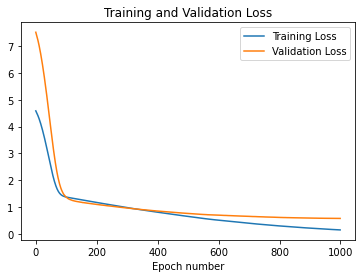

In [108]:
epochs_range = range(num_epochs)
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("Epoch number")
plt.show()

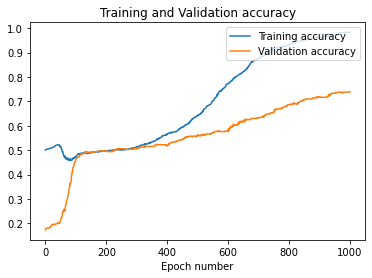

In [109]:
epochs_range = range(num_epochs)
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(epochs_range, accuracy, label='Training accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation accuracy')
plt.xlabel("Epoch number")
plt.show()

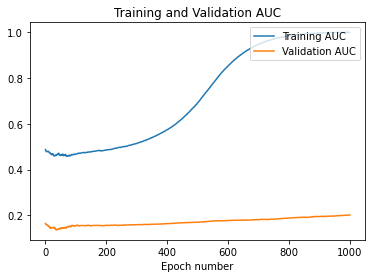

In [110]:
epochs_range = range(num_epochs)
auc = history.history['auc']
val_auc = history.history['val_auc']
plt.plot(epochs_range, auc, label='Training AUC')
plt.plot(epochs_range, val_auc, label='Validation AUC')
plt.legend(loc='upper right')
plt.title('Training and Validation AUC')
plt.xlabel("Epoch number")
plt.show()

#### Calculate predictions

In [111]:
predictions = model.predict([X_test, X_test_other])

#### Evaluate the model on the train, validation and test data

In [112]:
model.evaluate([X_train, X_train_other], Y_train)
model.evaluate([X_valid, X_valid_other], Y_valid)
model.evaluate([X_test, X_test_other], Y_test)
myPrint(noskill_score, hold=False)

14/14 [==============================] - 0s 866us/step - loss: 0.5359 - accuracy: 0.7518 - auc: 0.2099
[0.83403657 0.16596343]


#### Print examples of failed predictions

In [113]:
test_score = 0
for x in range(len(X_test)):
    if np.round(predictions[x])[0] != Y_test[x]:
      print(testing_titles[x])
      #print(titles[x + validation_cut])
      print("Score = ", dataset3[['score']].loc[x + validation_cut+1])
      print(int(np.round(predictions[x])[0])," ",Y_test[x])
      test_score += abs(int(np.round(predictions[x])[0]) - Y_test[x])
      print('\n')
    
myPrint("Test score = ", test_score, ", Total samples = ", len(X_test),hold=False)

Steve Wright merrily ruining Radio 2 for a few hours most days.
Score =  score    462
Name: 1707, dtype: int64
0   1


Went to the barbers today and was asked, ‘ What grade, mate?’. Not a sodding clue, my only hair related instructions is ‘ just a trim, please’. Clearly I’m from a different time zone.
Score =  score    9
Name: 1715, dtype: int64
1   0


Every time my wife and child leaves the house, I find myself having to turn every light off in the house when I'm supposed to be working. I mean I know for a fact they've not been in some of those rooms. At least now, I can retrain to be a lighthouse keeper. Plenty of experience.
Score =  score    564
Name: 1720, dtype: int64
0   1


The amount you're expected to pay for a stag/hen do
Score =  score    22
Name: 1721, dtype: int64
1   0


Being in school and hearing Year 7s saying things like ‘bussin’ and ‘no cap’ and I’m here, almost 18, not knowing what on earth they’re saying.
Score =  score    48
Name: 1724, dtype: int64
1   0


Supp

Score =  score    62
Name: 1912, dtype: int64
1   0


People that use CU Next Tuesday regularly but get offended when you call them a c**t
Score =  score    5
Name: 1913, dtype: int64
1   0


£437,500 for a 3 bed semi-detached new build in the town of Luton close to where I live (by Taylor Wimpey). At the rate England is going we are all going to be living in boxes.
Score =  score    590
Name: 1915, dtype: int64
0   1


I called my GP surgery 239 times between 8am and 830am for a phone appointment.
Score =  score    29
Name: 1916, dtype: int64
1   0


‘Please leave your name and number, and a Colleague will get right back to you” CLICK “I’m sorry, mailbox 3010220 is full”
Score =  score    13
Name: 1917, dtype: int64
1   0


For months I've been the Communal Milk Bringer for the office. This was apparently fair because "no one else uses it". I bring my own and name tag it, suddenly everyone loses their minds.
Score =  score    680
Name: 1920, dtype: int64
0   1


The "idea" of a Chines